In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Data on isotopes in primary circuit in normal operation
Primary = pd.read_excel(r'/Users/imemeulenbelt/Desktop/Data/Excel data/Used for Baseline/Edited Baseline data no zeros.xlsx')
# Setting Sample date time as index column
Primary['Sample Date-Time'] = pd.to_datetime(Primary['Sample Date-Time'], format='%Y/%m/%d %H:%M:%S')
Primary.set_index('Sample Date-Time', inplace=True)

# Drop some columns that aren't necessary
Primary.drop(columns=['Analysis Date-Time', 'Sample-Analysis time (hr aprox.)', 'Reactor start', 'Reactor stop', 'Sample ID','Unnamed: 45', 'Unnamed: 53','Baseline', 'Total', 'Average', 'Percentage', 'Total.1'], inplace=True)


In [5]:
class ElementConstants: # Only for gaseous products!
    isotopes_data = [
        #format: ("Isotope name", Lambda of isotope, Mass of isotope) if any isotope has to be added (like Ar-41) 
        ("Xe133", np.log(2) / (5.2475 * 3600 * 24), 133),
        ("Xe138", np.log(2) / (14.08 *60), 138),
        ("Xe135", np.log(2) / (9.14 * 3600), 135),
        ("Kr85m", 0.41e-4, 85),
        ("Kr87", 1.5e-4, 87),
    ]

    def __init__(self, element_name, lamb, M_iso):
        self.element_name = element_name
        self.lamb = lamb
        self.M_iso = M_iso
        self.calculate_constants()

    def calculate_constants(self):
        mu = 0.94e-5
        r = 0.037e-9
        k = 1.380649e-23
        M_H2 = 2
        R = 8.314e-3
        Temp = 273.15 + 42

        def D_water(k, T, mu, r, M_H2, M_iso):
            return k * T / (6 * np.pi * mu * r) * np.sqrt(M_H2 / M_iso)

        D_water_iso = D_water(k, Temp, mu, r, M_H2, self.M_iso)

        setattr(self, f"M_{self.element_name}", self.M_iso)
        setattr(self, f"Lamb_{self.element_name}", self.lamb)
        setattr(self, f"D_water_{self.element_name}", D_water_iso)

    @classmethod
    def calculate_all_isotope_constants(cls):
        isotope_constants = {}

        for name, lamb, M_iso in cls.isotopes_data:
            element_constants = cls(name, lamb, M_iso)
            M = getattr(element_constants, f"M_{name}")
            Lamb = getattr(element_constants, f"Lamb_{name}")
            D_water = getattr(element_constants, f"D_water_{name}")
            isotope_constants[name] = {'M': M, 'Lamb': Lamb, 'D_water': D_water}

        return isotope_constants


isotope_constants = ElementConstants.calculate_all_isotope_constants()

M_Kr87, Lamb_Kr87, D_water_Kr87 = isotope_constants["Kr87"].values()
M_Kr85m, Lamb_Kr85m, D_water_Kr85m = isotope_constants["Kr85m"].values()
M_Xe133, Lamb_Xe133, D_water_Xe133 = isotope_constants["Xe133"].values()
M_Xe135, Lamb_Xe135, D_water_Xe135 = isotope_constants["Xe135"].values()
M_Xe138, Lamb_Xe138, D_water_Xe138 = isotope_constants["Xe138"].values()

# Other products
def Effective_lamb(t_half_p, t_half_d):
    Lamb_p = np.log(2)/(t_half_p * 24 * 3600) # In days
    Lamb_d = np.log(2)/(t_half_d * 24 * 3600) # In days
    return (Lamb_p * Lamb_d)/(Lamb_p + Lamb_d)


# Other products
M_La140, Lamb_eff_La140, D_water_La140 = 140, Effective_lamb(12.75, 1.68), 6.2e-10 #m2/s
M_Cs137, Lamb_Cs137, D_clad_Cs137, D_water_Cs137 = 137, np.log(2)/(30*365*3600*24), 1e-20 , 9e-10#6e-12 #2.056e-9#6e-12


# Calculating isotope concentration based on neutronics

In [120]:


class IsotopeDiffusionTemperature:
    def __init__(self, M_Isotope, Lamb,  D_clad, D_water = None):
        self.M_Isotope = M_Isotope       # Isotope mass
        self.Lamb = Lamb                 # Decay constant
        self.D_water = D_water
        self.D_clad = D_clad

    def Finite_difference_scheme_gasses(self, M_H2, M, N, Lamb, dt, dx, f, Y, L, matrix_thickness, D_fuel):
        Mass_Isotope = self.M_Isotope    # Isotope mass
        Mass_Hydrogen = M_H2             # Hydrogen mass
        D_clad = self.D_clad             # Diffusion coefficient in the cladding

        u = np.zeros((N + 1, M + 1))     # Initialize concentration matrix
        u[N // 2, :] = f*Y                 # Set the production rate at the center of the fuel

        R_t = np.zeros(M + 1)            # Initialize the release rate array

        x = np.linspace(-L - matrix_thickness, L + matrix_thickness, N + 1)     # Spatial grid

        for j in range(M):
            for i in range(1, N):
                if -L - matrix_thickness < x[i] < -matrix_thickness or matrix_thickness < x[i] < L + matrix_thickness:
                    
                    ## Cladding regions
                    D = D_clad                                                # Calculate diffusion coefficient
                    
                    # Update concentration using the finite difference equation
                    u[i, j + 1] = u[i, j] + D * dt / dx ** 2 * (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) - self.Lamb * dt * u[i, j]
                
                elif -matrix_thickness <= x[i] <= matrix_thickness:
                    
                    ## Fuel region
                    D = D_fuel           # Use diffusion coefficient isotope in fuel
                    
                    # Update concentration using the finite difference equation
                    u[i, j + 1] = u[i, j] + D * dt / dx ** 2 * (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) - self.Lamb * dt * u[i, j] + f * dt

            u[0, j + 1] = u[0, j]        # Left boundary condition (Dirichlet) meaning that concentration is constant at edge left cladding
            u[N, j + 1] = u[N, j] + D * dt / dx * (u[N - 1, j] - u[N, j]) - self.Lamb * dt * u[N, j]  # Set the right boundary condition

            # Identify the index corresponding to the boundary between fuel and cladding
            boundary_idx = np.argmin(np.abs(x - matrix_thickness))
            
            # Diffusion rate at the boundary between the fuel and cladding
            dc_dx = (u[N - 1, j] - u[N, j]) / dx
            
            D_boundary = D_clad
            J = -D_boundary * dc_dx                                       # Flux at the boundary
            A = 1  # Area
            R_t[j + 1] = (-J * A)                                            # Update the release rate
        print('The concentration after the used time is', np.round(np.max(u),3))

        return u, R_t
  
    def run_simulation(self, T_gas, T_water, isotope_name, matrix_thickness, Y, D_fuel):
        A = 1  # Area
        R = 8.314e-3                                     # Gas constant in kJ/(mol*K)
        Temp = 273.15 + 42                               # Temperature in Kelvin

        M_H2 = 2                                         # Hydrogen mass

        f = 7.56143319670973e+19 * Y
        L = 0.00057                                      # Half-width of the fuel
        N = 200                                          # Number of spatial steps
        M_gas = 40000                                    # Number of time steps

        L_matrix = -matrix_thickness                     # Left matrix thickness
        L_total = L - L_matrix                           # Total length of the fuel

        N_total = N + int(N * (matrix_thickness / L))    # Total number of spatial steps

        dx = L_total / N_total                           # Spatial step size
        dt_gas = T_gas / M_gas                           # Time step size

        x = np.linspace(-L - matrix_thickness, L + matrix_thickness, N + 1)  # Spatial grid

        t_gas = np.linspace(0, T_gas, M_gas + 1)                             # Time grid
        
    
        # Update the method call to include the modified N_total
        u_gas, R_t_gas = self.Finite_difference_scheme_gasses(M_H2, M_gas, N, self.Lamb, dt_gas, dx, f,Y, L, matrix_thickness, D_fuel)


In [121]:
T_gas = 6 * 24.7 * 24 * 3600 # Max time to run for gass diffusion through aluminium
T_water = 1000 # Max time to run for gass diffusion through water. Must be small, otherwise the differential equation has an unbound solution.

Y = 0.059
matrix_thickness = 0.00076/2 # m https://inis.iaea.org/collection/NCLCollectionStore/_Public/40/082/40082712.pdf?r=1 at Qualification program for JHR fuel elements


In [122]:
isotope = IsotopeDiffusionTemperature(M_Cs137, Lamb_Cs137, D_clad_Cs137, D_water_Cs137)
isotope.run_simulation(T_gas, T_water, 'Cs137', matrix_thickness, Y, D_fuel=4e-20)


The concentration after the used time is 5.685682645975834e+25


# Calculating Cs-137 concentration using Burn-up

In [45]:
# Average Burn-up
P1_BUA = 0.3735
P2_BUA = 0.3549
P3_BUA = 0.3612

# Max Burn-up
P1_BUM = 0.5033
P2_BUM = 0.4721
P3_BUM = 0.4861

# Other parameters
C_U    = 4.8e6        # g/m3
Enrich = 0.2          # Enrichment
M_U238 = 238.05078826 # g/mol
M_U235 = 235.0439299  # g/mol
Y_Cs137= 0.059


# Relevant constants
N_A    = 6.02214076e23  # mol-1

def Uranium_concentration(M_U238, M_U235, C_U, Enrich, N_A):
    return C_U * N_A / (M_U238*(1 - Enrich ) + M_U235 * Enrich)  # Particles/m3


# Results
Uranium_concentration = Uranium_concentration(M_U238, M_U235, C_U, Enrich, N_A)

P1_Cs137A = Uranium_concentration * P1_BUA * Y_Cs137
P2_Cs137A = Uranium_concentration * P2_BUA * Y_Cs137
P3_Cs137A = Uranium_concentration * P3_BUA * Y_Cs137

P1_Cs137M = Uranium_concentration * P1_BUM * Y_Cs137
P2_Cs137M = Uranium_concentration * P2_BUM * Y_Cs137
P3_Cs137M = Uranium_concentration * P3_BUM * Y_Cs137

t_op_sip = 4*365*24*3600   # Correction to time
Average_average_Cs137 = (P1_Cs137A + P2_Cs137A + P2_Cs137A)/3 * np.exp(-t_op_sip*Lamb_Cs137)
Average_max_Cs137 = (P1_Cs137M + P2_Cs137M + P3_Cs137M)/3 * np.exp(-t_op_sip*Lamb_Cs137)

Average_min_Cs137 = Average_average_Cs137 - (Average_max_Cs137 - Average_average_Cs137) * np.exp(-t_op_sip*Lamb_Cs137)

In [46]:
print('The average Cs137 concentration for the average burnup for the rods is', Average_average_Cs137 )
print('The average Cs137 concentration for the Maximal burnup for the rods is',Average_max_Cs137)

print('The average Cs137 concentration for the Minimal burnup for the rods is', Average_min_Cs137)


The average Cs137 concentration for the average burnup for the rods is 2.3646300274814693e+26
The average Cs137 concentration for the Maximal burnup for the rods is 3.1901659606426366e+26
The average Cs137 concentration for the Minimal burnup for the rods is 1.61197035210554e+26


### The calculated values above:

Calculated concentration of Cs-137 concentration for a fuel rod that has been in the reactor for 6 cycles of 24.7 days: 1.25e26

With Burn-up average concentration: 2.59e26


# Visualising results based on different release coefficients

In [168]:
class IsotopeDiffusionDefectWater:
    def __init__(self, M_Isotope, Lamb, D_clad, A_defect, D_water=None):
        self.M_Isotope = M_Isotope
        self.Lamb = Lamb
        self.D_water = D_water
        self.A_defect = A_defect
        self.D = D_water
   
    def Finite_difference_scheme_defect(self, M, N, Lamb, dt, dx, f):
        D = self.D

        u = np.zeros((N+1, M+1))
        u[0, :] = f

        R_t = np.zeros(M+1)

        for j in range(M):
            for i in range(1, N):
                u[i, j+1] = u[i, j] + D * dt / dx**2 * (u[i+1, j] - 2*u[i, j] + u[i-1, j]) - self.Lamb * dt * u[i, j]
            u[0, j+1] = u[0, j]
            u[N, j+1] = u[N, j] + D * dt / dx * (u[N-1, j] - u[N, j]) - self.Lamb * u[N, j]

            dc_dx = (u[N-1, j] - u[N, j]) / dx
            J = -D * dc_dx
            A = self.A_defect
            R_t[j+1] = -J * A

        return u, R_t

        
    def run_simulation(self, T, isotope_name, matrix_thickness, D_fuel, f):
        A = 1  # Area

        L = 0.00057                                      # Half-width of the fuel
        N = 50                                          # Number of spatial steps
        M = 90000                                        # Number of time steps

        #L_matrix = -matrix_thickness                     # Left matrix thickness
        L_total = L                            # Total length of the fuel

        N_total = N     # Total number of spatial steps

        dx = L_total / N_total                           # Spatial step size
        dt = T / M                                   # Time step size

        x = np.linspace(0, L, N + 1)  # Spatial grid
        t_gas = np.linspace(0, T, M + 1)                             # Time grid


        # Update the method call to include the modified N_total
        u_gas, R_t_gas = self.Finite_difference_scheme_defect(M, N, self.Lamb, dt, dx, f)
        plt.plot(t_gas, R_t_gas)
        plt.grid()
        plt.xlabel('Time[s]')
        plt.ylabel(r'Release Rate [#/s]')


        # Inside the Finite_difference_scheme_gasses method
        R_t_gas_normalized = R_t_gas / M

        total_release_gas = np.sum(R_t_gas_normalized) * T
        print('The total gas release over time', T, '[s] is', np.round(total_release_gas,1))
        print('The steady state gas release rate is',  np.round(np.max(R_t_gas),1))
        return np.max(R_t_gas)
    

In [164]:
A_defect = 4.063972448718164e-09
A_defect_upper = 6.058420012972961e-09
A_defect_lower = 6.080956826364004e-10

f = Average_average_Cs137 
f_upper = Average_max_Cs137
f_lower = Average_min_Cs137

matrix_thickness = 0.00076/2

T_Defect = 1000#4 * 365 * 24 * 3600

The total gas release over time 1000 [s] is 3731821384.6
The steady state gas release rate is 34463149.0
The total gas release over time 1000 [s] is 2543985892.7
The steady state gas release rate is 23493558.7
The total gas release over time 1000 [s] is 5034669023.9
The steady state gas release rate is 46494869.6
The total gas release over time 1000 [s] is 5563261475.5
The steady state gas release rate is 51376389.5
The total gas release over time 1000 [s] is 558395634.1
The steady state gas release rate is 5156750.5
The total gas release over time 1000 [s] is 178492198663.5
The steady state gas release rate is 1091239783.9
The total gas release over time 1000 [s] is 121678287505.4
The steady state gas release rate is 743899112.4
The total gas release over time 1000 [s] is 240807115616.0
The steady state gas release rate is 1472211708.8
The total gas release over time 1000 [s] is 266089576686.0
The steady state gas release rate is 1626779962.0
The total gas release over time 1000 [s] i

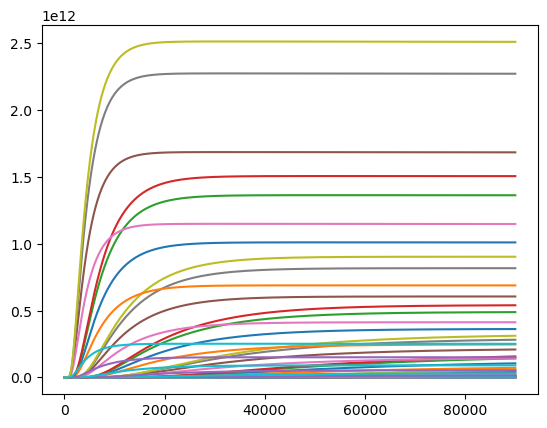

In [123]:
# Calculate the logarithm (base 10) of the ending value
log_end = np.log10(3e-9)

# Generate the logspace
D_water_values = np.logspace(-11, log_end, 10)


# Initialize arrays to store the release rates
max_release_rates = np.zeros(D_water_values.shape)
max_release_rates_lower = np.zeros(D_water_values.shape)
max_release_rates_upper = np.zeros(D_water_values.shape)

max_release_rates_A_defect_upper = np.zeros(D_water_values.shape)
max_release_rates_A_defect_lower = np.zeros(D_water_values.shape)


# Loop over D_water_values
for i, D_water_Cs137 in enumerate(D_water_values):
    # Run the simulation for the average f
    isotope = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect, D_water_Cs137)
    max_release_rates[i] = isotope.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_average_Cs137)
    
    # Run the simulation for the lower bound of f
    isotope_lower = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect, D_water_Cs137)
    max_release_rates_lower[i] = isotope_lower.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_min_Cs137)
    
    # Run the simulation for the upper bound of f
    isotope_upper = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect, D_water_Cs137)
    max_release_rates_upper[i] = isotope_upper.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_max_Cs137)

     # Run the simulation for the upper bound of A_defect
    isotope_A_defect_upper = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect_upper, D_water_Cs137)
    max_release_rates_A_defect_upper[i] = isotope_A_defect_upper.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_average_Cs137)
    
    # Run the simulation for the lower bound of A_defect
    isotope_A_defect_lower = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect_lower, D_water_Cs137)
    max_release_rates_A_defect_lower[i] = isotope_A_defect_lower.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_average_Cs137)

/var/folders/zv/42kjntbn5cq7mb4xfbb4xcnc0000gn/T/ipykernel_39305/2400001942.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(D_water_values, max_release_rates, yerr=[yerr_lower, yerr_upper], fmt='o-', ls = '--', label='Estimated Release Rate')
/var/folders/zv/42kjntbn5cq7mb4xfbb4xcnc0000gn/T/ipykernel_39305/2400001942.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(D_water_values, max_release_rates, yerr=[yerr_A_defect_lower, yerr_A_defect_upper], fmt='x-', ls = '')


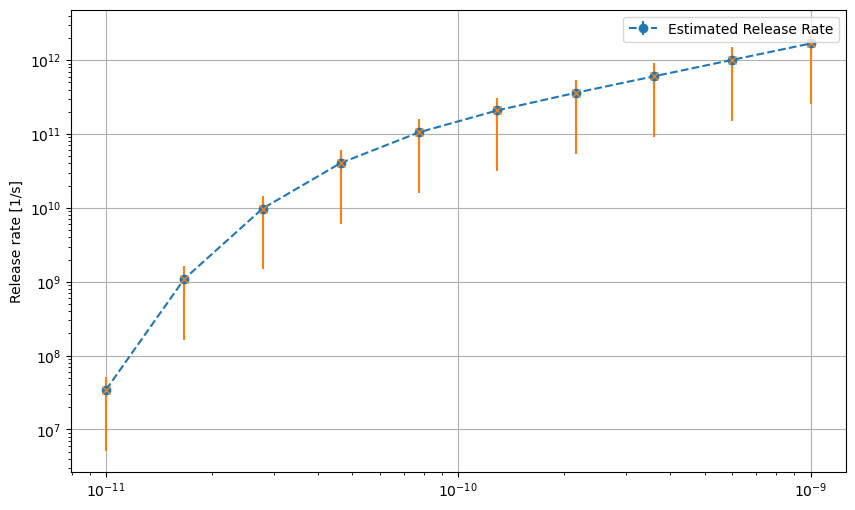

In [185]:
# Calculate the error bars
yerr_lower = max_release_rates - max_release_rates_lower
yerr_upper = max_release_rates_upper - max_release_rates

yerr_A_defect_lower = max_release_rates - max_release_rates_A_defect_lower
yerr_A_defect_upper = max_release_rates_A_defect_upper - max_release_rates

plt.figure(figsize=(10, 6))

# Existing error bars for f
plt.errorbar(D_water_values, max_release_rates, yerr=[yerr_lower, yerr_upper], fmt='o-', ls = '--', label='Estimated Release Rate')

# New error bars for A_defect
plt.errorbar(D_water_values, max_release_rates, yerr=[yerr_A_defect_lower, yerr_A_defect_upper], fmt='x-', ls = '')

#plt.title('Release rate of Cs-137 per second for different diffusion coefficients')
#plt.xlabel('Diffusion coefficient Cs-137 in water [m2/s]')
plt.ylabel('Release rate [1/s]')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-9, 2e-9)
plt.grid(True)
plt.legend()
plt.show()


In [170]:
# Assuming:
# Sample is 50mL, there is 1000m3 involved in the experiment (calculated in 2020 Defect as sampling volume)
# Sampling occurs over 30 minutes and the concentration Cs137 steadily increases (thus average is 15 minutes)

def Exp_measurement_50mL_Sample(Lamb, release, sample_size, volume, time):
    return Lamb * release * time * sample_size / volume

yerr_lower_exp = Exp_measurement_50mL_Sample(Lamb_Cs137, max_release_rates, 50e-6, 0.065, 5 * 60) - Exp_measurement_50mL_Sample(Lamb_Cs137, max_release_rates_lower, 50e-6, 1e3, 30 * 60)
yerr_upper_exp = Exp_measurement_50mL_Sample(Lamb_Cs137, max_release_rates_upper, 50e-6, 0.065, 5 * 60) - Exp_measurement_50mL_Sample(Lamb_Cs137, max_release_rates, 50e-6, 1e3, 30 * 60)

Exp_measured_50mL_Sample = Exp_measurement_50mL_Sample(Lamb_Cs137, max_release_rates, 50e-6, 0.065, 5 * 60)


/var/folders/zv/42kjntbn5cq7mb4xfbb4xcnc0000gn/T/ipykernel_39305/3920507425.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(D_water_values, Exp_measured_50mL_Sample, yerr = [yerr_lower_exp, yerr_upper_exp], fmt='o-', ls = '--')


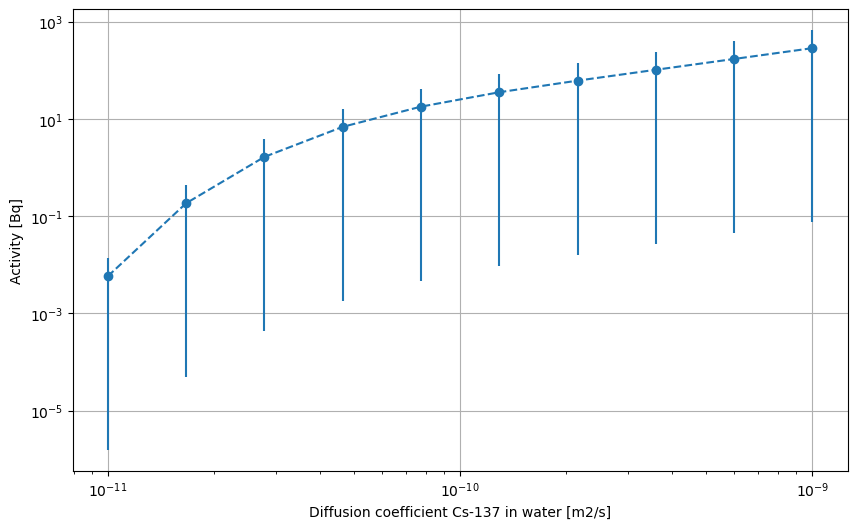

In [180]:
# plot max_release_rates over D_clad_values
plt.figure(figsize=(10, 6))
plt.errorbar(D_water_values, Exp_measured_50mL_Sample, yerr = [yerr_lower_exp, yerr_upper_exp], fmt='o-', ls = '--')
#plt.title('Expected measurement of Cs-137 in 50mL sample for different diffusion coefficients')
plt.xlabel('Diffusion coefficient Cs-137 in water [m2/s]')
plt.ylabel('Activity [Bq]')
#plt.xlim(1e-9, 1e-8)
#plt.ylim(1e-5, np.max(Exp_measured_50mL_Sample))
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

# Activity in a sample using literature RC through water

The total gas release over time 1000 [s] is 3368477850209045.0
The steady state gas release rate is 3463667734284.5
The total gas release over time 1000 [s] is 6774736308029706.0
The steady state gas release rate is 6966183719139.6
The total gas release over time 1000 [s] is 343596483601412.6
The steady state gas release rate is 353306183619.4


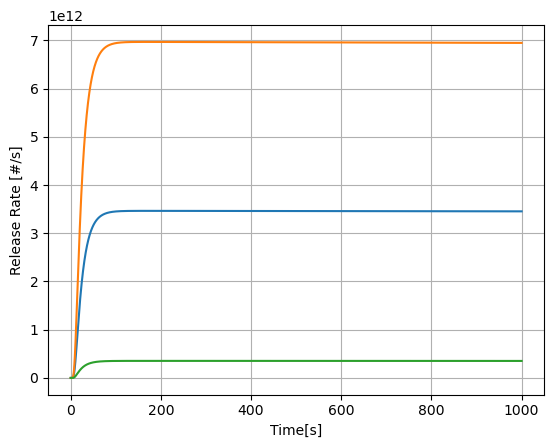

In [171]:
D_water_Cs137 = 2.056e-9


A_defect = 4.063972448718164e-09                # Expected defect size 2019 defect [m^2]
A_defect_upper = 6.058420012972961e-09          # Expected upper limit of defect size 2019 defect [m^2]
A_defect_lower = 6.080956826364004e-10          # Expected lower limit of defect size 2019 defect [m^2]

f = Average_average_Cs137                       # Calculated averaga concentration Cs-137 in the fuel
f_upper = Average_max_Cs137                     # Calculated highest concentration Cs-137 in the fuel
f_lower = Average_min_Cs137                     # Calculated lowest concentration Cs-137 in the fuel

#Initialise class
isotope = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect, D_water_Cs137)
isotope_upper = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect_upper, D_water_Cs137)
isotope_lower = IsotopeDiffusionDefectWater(M_Cs137, Lamb_Cs137, D_clad_Cs137, A_defect_lower, D_water_Cs137)

# Calculate concentration and upper lower limits
Cs137_release = isotope.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_average_Cs137)

Cs137_release_upper = isotope_upper.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_max_Cs137)
Cs137_release_lower = isotope_lower.run_simulation(T_Defect, 'Cs-137', matrix_thickness, D_fuel=4e-23, f=Average_min_Cs137)



In [166]:

sample_size = 50e-6    #m3
volume      = 0.065     #m3
time        = 5*60  #s

Cs137_meas_min = Exp_measurement_50mL_Sample(Lamb_Cs137, Cs137_release_lower, sample_size, volume, time)
Cs137_meas_max = Exp_measurement_50mL_Sample(Lamb_Cs137, Cs137_release_upper, sample_size, volume, time)
Cs137_meas     = Exp_measurement_50mL_Sample(Lamb_Cs137, Cs137_release, sample_size, volume, time)

In [173]:
print('The expected measured activity Cs-137 in a 50ml sample for defect size 4.06e-9m2 after 4 years is')
print(np.round(Cs137_meas,4), 'Bq','with lower bound', np.round(Cs137_meas_min,4), 'Bq, and upper bound', np.round(Cs137_meas_max,4), 'Bq')

The expected measured activity Cs-137 in a 50ml sample for defect size 4.06e-9m2 after 4 years is
0.0381 Bq with lower bound 0.0039 Bq, and upper bound 0.0766 Bq


# Release through fuel

In [208]:
import numpy as np
import matplotlib.pyplot as plt

class ReleaseRateCalculation:
    def __init__(self, M_Isotope, Lamb, T_gas):
        self.M_Isotope = M_Isotope       # Isotope mass
        self.Lamb = Lamb                 # Decay constant
        self.T_gas = T_gas

    def Finite_difference_scheme_gasses(self, M, N, Lamb, D, steady_concentration):
        A = 47.5/20  # Area
        R = 8.314e-3                                     # Gas constant in kJ/(mol*K)

        M_H2 = 4                                         # Hydrogen mass

        L = 0.00038                                      # Cladding thickness
        M_gas = M

        N_total = N     # Total number of spatial steps

        dx = L / N_total                           # Spatial step size
        dt = self.T_gas / M_gas                           # Time step size


        u = np.zeros((N+1, M+1))
        u[0, :] = steady_concentration 

        R_t = np.zeros(M+1)

        x = np.linspace(0, L, N+1)

        for j in range(M):
            for i in range(1, N):
                # Check the stability condition within the loop after D is calculated
                if D * dt / dx**2 > 0.5:
                    # Possible values for N and M to satisfy the stability condition
                    N_option1, M_option1 = int(D * self.T_gas / dx**2 * 2), M
                    N_option2, M_option2 = N, int(D * self.T_gas / dx**2 * 2)
                    N_option3, M_option3 = int(D * self.T_gas / dx**2), int(D * self.T_gas / dx**2)
                    print(f"Stability condition not satisfied. Change N or M to such that it is met. "
                          f"Examples that are possible with this diffusion coefficient are: "
                          f"N={N_option1}, M={M_option1}; "
                          f"N={N_option2}, M={M_option2}; "
                          f"N={N_option3}, M={M_option3}")
                    return
                
                u[i, j+1] = u[i, j] + D * dt / dx**2 * (u[i+1, j] - 2*u[i, j] + u[i-1, j]) - self.Lamb * dt * u[i, j]
            
            u[0, j+1] = u[0, j]

            u[N, j+1] = u[N, j] + D * dt / dx * (u[N-1, j] - u[N, j]) - self.Lamb * u[N, j]

            dc_dx = (u[N-1, j] - u[N, j]) / dx
            J = -D * dc_dx
            A = 1
            R_t[j+1] = -J * A
            
        
        t_gas = np.linspace(0, self.T_gas, M_gas+1)
        #plt.figure(figsize = [12,6])
        plt.plot(t_gas/(24*3600), R_t, label=f'{np.round(D*1e17,3)} [e-17 m^2/s]')
        plt.xlabel('Time [d]')
        plt.ylabel('Unit release rate [m2]')
        #plt.title('Release rate through aluminum')
        plt.grid()
        plt.legend()
        return u, R_t[-1]



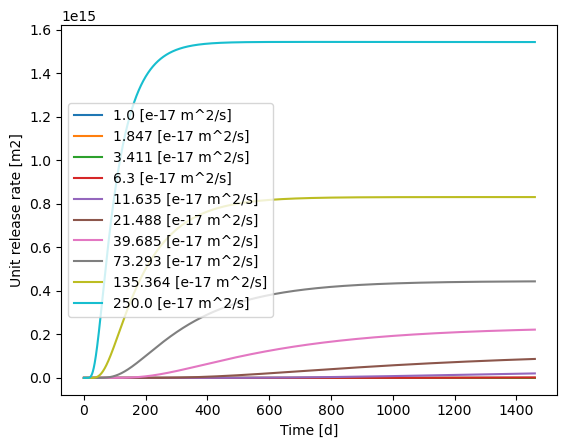

In [209]:

# Your existing code for constants and functions
T = 4 * 365 * 24 * 3600  # 4 years cooldown time
N = 20
M = 100000

2.5012855622400775e-15

# Initialize an empty list to store the results
exp_releases = []

# Calculate the logarithm (base 10) of the ending value
log_end = np.log10(2.5e-15)

diff_coeffs = np.logspace(-17, log_end, 10)  # Array of diffusion coefficients, adjust as needed

# Loop over different diffusion coefficients
for Estimated_Diff_Coeff_I in diff_coeffs:
    Cs137 = ReleaseRateCalculation(M_Cs137, Lamb_Cs137, T)
    _, release_rate_Cs137 = Cs137.Finite_difference_scheme_gasses(M, N, Lamb_Cs137, Estimated_Diff_Coeff_I, Average_average_Cs137)
    St_st_release_Cs137 = np.max(release_rate_Cs137)
    Exp_in_sample_clad_release = Exp_measurement_50mL_Sample(Lamb_Cs137, St_st_release_Cs137, sample_size, volume, time)
    exp_releases.append(Exp_in_sample_clad_release)
